<a href="https://colab.research.google.com/github/makhthum/MDS_Deakin_SIG742/blob/main/sit742task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![Deakin University](https://www.freelogovectors.net/svg11/deakin-university-logo_freelogovectors.net.svg)

#Master of Data Science (MDS)
###SIG 742 – Modern Data Science | Trimester 2, 2025
####End Term Assesment 2025 - Group 1 - Team 6

---



Student Id   |     Student Name   
S225450659   |     Syed. Makhthum Peera    

# Part 1 - Data Acquisition and Manipulation

There are 8 questions in this part, totalling 60 marks. Each of question is worth 5 marks. Additionally, the quality of your explanation in both the report and video will collectively be worth 20 marks.   

You are recommended to use Google Colab to finish all the coding in the code block cell, and provide sufficient coding comments, and also save the result of running as well.   

The (business_review_submission.zip) data used for this part could be found in here. There are two files in the data. The first one is about the business review submission with many companies. For each of the row, the review submission is provided with relevant information such as user id, time, name and many others. The second one is the meta information of the business and the two data could be joined with gmap_id. You will need to use spark to first read the unzipped (csv) review data for starting and later join the meta review business data on dataframe (pandas or spark). You could find the code on reading csv data with Spark from M04G. In some of the tasks, if the question is not specifically asking to use spark, you could use both pandas and numpy.

https://github.com/tulip-lab/sit742/blob/develop/Jupyter/data/business_review_submission.zip

## Q1.1
Using PySpark to do some data wrangling process, so that:   
1.1.1 For the none or null in text column, change it to 'no review'.   
1.1.2 Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime and show the first 5 rows.  

In [31]:
import zipfile
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, when, from_unixtime, count
from pyspark.sql.types import FloatType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Ans 1.1

In [32]:
# Define the path to the zip file and the extraction directory
zip_file_path = '/content/business_review_submission.zip'
extract_dir = '/content/extracted_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Zip file extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")
    # You might want to add steps here to handle the error,
    # e.g., re-download the file or notify the user.


# List the extracted files to find the review submission csv file
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

# Assuming the review submission csv file is one of the extracted files, find it.
# You might need to adjust the filename based on the actual content of the zip.
review_csv_file = None
for file in extracted_files:
    if 'review.csv' in file:
        review_csv_file = os.path.join(extract_dir, file)
        break

if review_csv_file:
    print(f"Review submission file found: {review_csv_file}")

    # Initialize SparkSession
    spark = SparkSession.builder.appName("BusinessReviewAnalysis").getOrCreate()

    # Load the review data
    # review_df_spark = spark.read.csv(review_csv_file, header=True, inferSchema=True)
    try:
      review_df_spark = spark.read.csv(
        review_csv_file,
        header=True,          # Use first row as header
        inferSchema=True,     # Let Spark infer column types
        quote='"',            # Respect double quotes around text
        escape='"',           # Handle escaped quotes
        multiLine=True        # If text fields contain newlines
      )
      print("DataFrame successfully loaded.")
      review_df_spark.show(15)
      review_df_spark.printSchema()
    except Exception as e:
        print(f"Error loading DataFrame: {e}")

    # 1.1.1 For the none or null in text column, change it to 'no review'.
    review_df_spark = review_df_spark.withColumn("text", when(col("text").isNull(), "no review").otherwise(col("text")))

    # 1.1.2 Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime
    # Convert bigint 'time' to timestamp before formatting
    review_df_spark = review_df_spark.withColumn("newtime", date_format(from_unixtime(col("time")/1000), "yyyy-MM-dd"))

    # Show the first 15 rows with the newtime column
    review_df_spark.show(15)

else:
    print("Review submission CSV file not found in the zip.")

Zip file extracted successfully.
Extracted files: ['review.csv', 'meta-review-business.csv']
Review submission file found: /content/extracted_data/review.csv
DataFrame successfully loaded.
+--------------------+-----------------+-------------+------+--------------------+--------------------+----+--------------------+
|             user_id|             name|         time|rating|                text|                pics|resp|             gmap_id|
+--------------------+-----------------+-------------+------+--------------------+--------------------+----+--------------------+
|1.091298048426862E20|       Nicki Gore|1566331951619|     5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|    Allen Ratliff|1504917982385|     5|Great campground ...|                NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|Jonathan Tringali|1474765901185|     4|We tent camped he...|                NULL|NULL|0x56b646ed2220b77...|
|1.103291551475920...|         

## Q1.2
Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is required to be done:   

1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.   

1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.   

1.2.3 Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between gmap_id and reivew_time. You could explore for example, what is the time people usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you are finding with your visualizations in the markdown cell. Please also include your findings and visualizations in the report.

### Ans 1.2

In [33]:
# 1.2.1 Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

# Calculate the number of reviews per gmap_id
reviews_per_gmap_id_spark = review_df_spark.groupBy("gmap_id").agg(count("*").alias("review_count"))

# Cast the review_count to FloatType
reviews_per_gmap_id_spark = reviews_per_gmap_id_spark.withColumn("review_count", col("review_count").cast(FloatType()))

# Show the top 5 rows
print("Number of reviews per unique gmap_id (PySpark DataFrame - top 5):")
reviews_per_gmap_id_spark.show(5)

Number of reviews per unique gmap_id (PySpark DataFrame - top 5):
+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        27.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows



In [34]:
# 1.2.2 Transform the current pyspark dataframe to pandas dataframe (named as df)
df = review_df_spark.toPandas()

# create the column reivew_time with the information of review time on hours level.
df['review_time'] = pd.to_datetime(df['time'], unit='ms').dt.hour

# Print your df pandas dataframe with top 5 rows after creating the column review_time.
print("\nPandas DataFrame with review_time (top 5):")
display(df.head())


Pandas DataFrame with review_time (top 5):


,user_id,name,time,rating,text,pics,resp,gmap_id,newtime,review_time
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-25,1
3,1.103292e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-02,23
4,1.089896e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2018-06-22,6


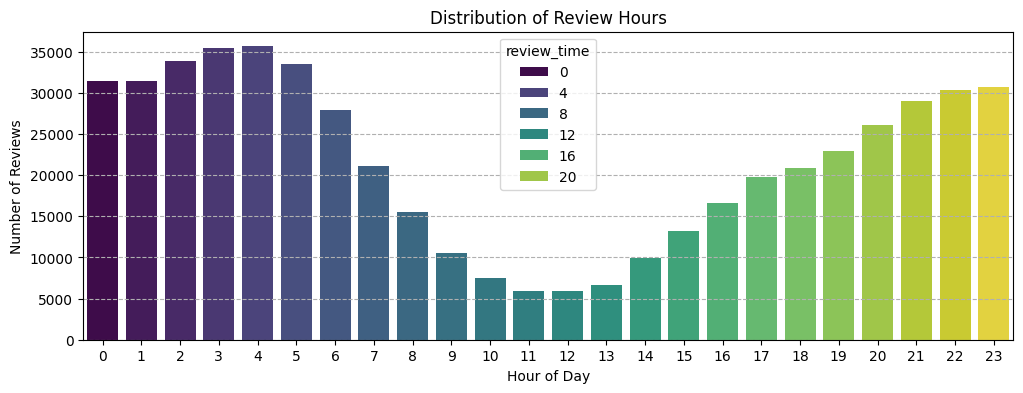

In [35]:
# 1.2.3 Using matplotlib or seaborn to draw some (two or more if possible) visualizations

# Example Visualization 1: Distribution of review hours
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='review_time', palette='viridis', hue='review_time')
plt.title('Distribution of Review Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--')
plt.show()

/tmp/ipython-input-3161257687.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


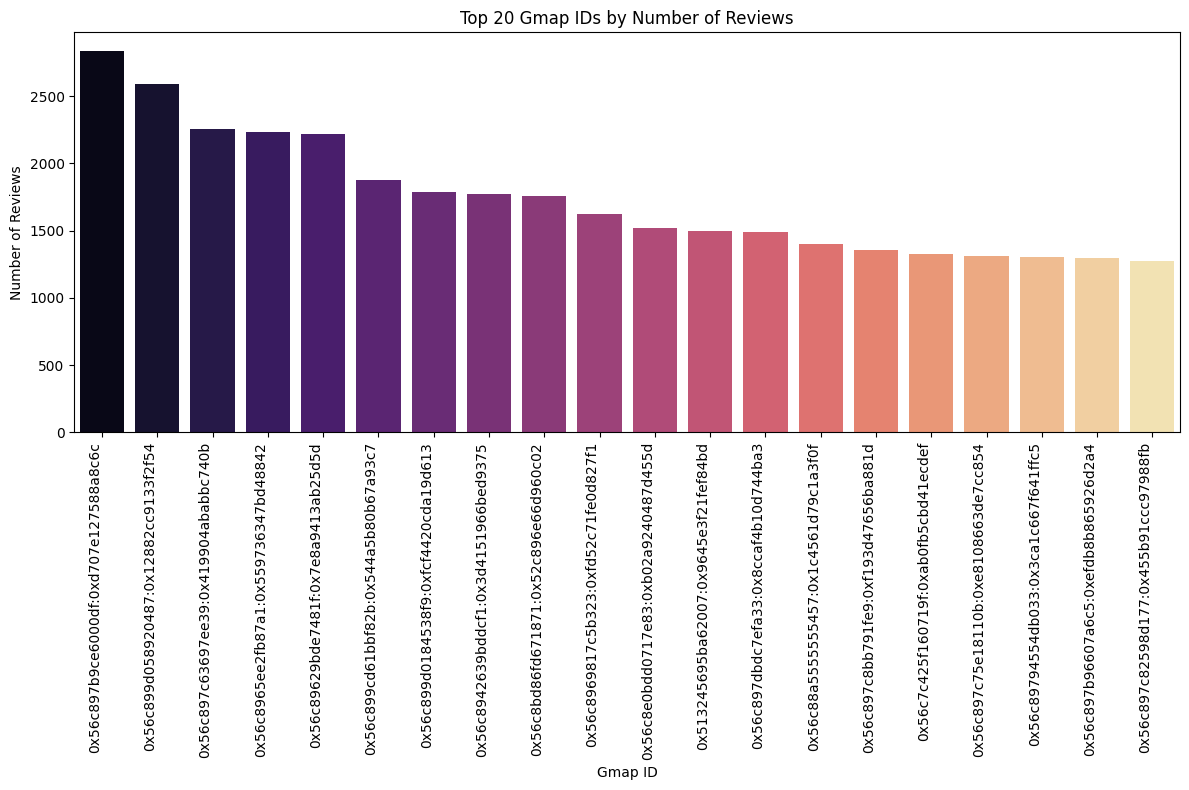

In [43]:
# Example Visualization 2: Number of reviews per gmap_id (using the calculated counts)
# First, convert the reviews_per_gmap_id_spark to pandas for easier plotting
reviews_per_gmap_id_pandas = reviews_per_gmap_id_spark.toPandas()
reviews_per_gmap_id_pandas_sorted = reviews_per_gmap_id_pandas.sort_values(by='review_count', ascending=False)

plt.figure(figsize=(12, 8))
# Displaying top 20 gmap_ids for better visualization
ax = sns.barplot(data=reviews_per_gmap_id_pandas_sorted.head(20), x='gmap_id', y='review_count', palette='magma', hue='gmap_id')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 20 Gmap IDs by Number of Reviews')
plt.xlabel('Gmap ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Q1.3

Let’s continue to analyze the reivew_time with reviews and related gmap_id. You need to use another data meta-business to join with the current dataframe on gmap_id.   

1.3.1 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).

1.3.2 Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you need to find out from 1.3.1), and find out which category those businesses are from?

1.3.3 Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

### Ans 1.3

In [44]:
# Construct the full path to the "meta-review-business.csv" file
meta_business_csv_file = os.path.join(extract_dir, 'meta-review-business.csv')

# Load the meta-review-business.csv file into a pandas DataFrame
meta_business_df = pd.read_csv(meta_business_csv_file)

In [47]:
# Display the first 5 rows of the meta_business_df DataFrame
print("Meta Business DataFrame (top 5):")
meta_business_df.head()

Meta Business DataFrame (top 5):


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Bear Creek Cabins & RV Park,"Bear Creek Cabins & RV Park, 3181 Richardson H...",0x56b646ed2220b77f:0xd8975e316de80952,NaN,61.100644,-146.214552,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18,NaN,NaN,NaN,NaN,"['0x56b6445fd9f9e387:0x6dd3d374ef56431a', '0x5...",https://www.google.com/maps/place//data=!4m2!3...
1,Anchorage Market,"Anchorage Market, 88th Ave, Anchorage, AK 99515",0x56c8992b5dee7225:0x9f7f4bf151868cf7,NaN,61.141435,-149.868482,"[""Farmers' market""]",4.2,18,NaN,"[['Thursday', 'Closed'], ['Friday', '10AM–5PM'...","{'Service options': ['In-store shopping'], 'Ac...",Closed ⋅ Opens 10AM Fri,NaN,https://www.google.com/maps/place//data=!4m2!3...
2,Happy Camper RV,"Happy Camper RV, 1151 N Shenandoah Dr # 4, Pal...",0x56c8e0455225be87:0xf24828df75e2f8ae,NaN,61.591856,-149.290657,['RV repair shop'],4.4,28,NaN,NaN,{'Accessibility': ['Wheelchair accessible entr...,NaN,"['0x56c8e104d9929a1d:0x2070ad63defadbf', '0x56...",https://www.google.com/maps/place//data=!4m2!3...
3,Cajun Corner,"Cajun Corner, 302 G St, Anchorage, AK 99501",0x56c8bdb5d91017cd:0xca19fd9afceed343,NaN,61.219378,-149.895852,['American restaurant'],4.5,24,NaN,"[['Wednesday', '11AM–2PM'], ['Thursday', '11AM...","{'Service options': ['Takeout', 'Dine-in', 'De...",Closed ⋅ Opens 11AM Thu,NaN,https://www.google.com/maps/place//data=!4m2!3...
4,Alaska General Seafoods,"Alaska General Seafoods, 980 Stedman St, Ketch...",0x540c251956395673:0x16f5a4fe26c18931,NaN,55.336119,-131.630669,"['Seafood wholesaler', 'Food']",4.7,8,NaN,"[['Wednesday', '7AM–11PM'], ['Thursday', '7AM–...",NaN,Open ⋅ Closes 11PM,"['0x540c25a882a72685:0xac5663d19d0a1893', '0x5...",https://www.google.com/maps/place//data=!4m2!3...


In [48]:
# Display the information of the meta_business_df DataFrame
print("\nMeta Business DataFrame Info:")
meta_business_df.info()


Meta Business DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12774 entries, 0 to 12773
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              12774 non-null  object 
 1   address           12606 non-null  object 
 2   gmap_id           12774 non-null  object 
 3   description       1516 non-null   object 
 4   latitude          12774 non-null  float64
 5   longitude         12774 non-null  float64
 6   category          12712 non-null  object 
 7   avg_rating        12774 non-null  float64
 8   num_of_reviews    12774 non-null  int64  
 9   price             1585 non-null   object 
 10  hours             8684 non-null   object 
 11  MISC              9387 non-null   object 
 12  state             8062 non-null   object 
 13  relative_results  10966 non-null  object 
 14  url               12774 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.5+ M

In [49]:
# Join the review DataFrame (df) with the meta business DataFrame (meta_business_df) on 'gmap_id'
merged_df = pd.merge(df, meta_business_df[['gmap_id', 'name', 'category', 'avg_rating', 'num_of_reviews']], on='gmap_id', how='left')

# Rename columns to distinguish between review name and business name
merged_df.rename(columns={'name_x': 'reviewer_name', 'name_y': 'business_name'}, inplace=True)

# Display the first few rows of the merged DataFrame
print("Merged DataFrame (top 5):")
display(merged_df.head())

Merged DataFrame (top 5):


,user_id,reviewer_name,time,rating,text,pics,resp,gmap_id,newtime,review_time,business_name,category,avg_rating,num_of_reviews
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20,Bear Creek Cabins & RV Park,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18
1,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20,Bear Creek Cabins & RV Park,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18
2,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0,Bear Creek Cabins & RV Park,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18
3,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0,Bear Creek Cabins & RV Park,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18
4,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-25,1,Bear Creek Cabins & RV Park,"['RV park', 'Cabin rental agency', 'Campground']",4.5,18


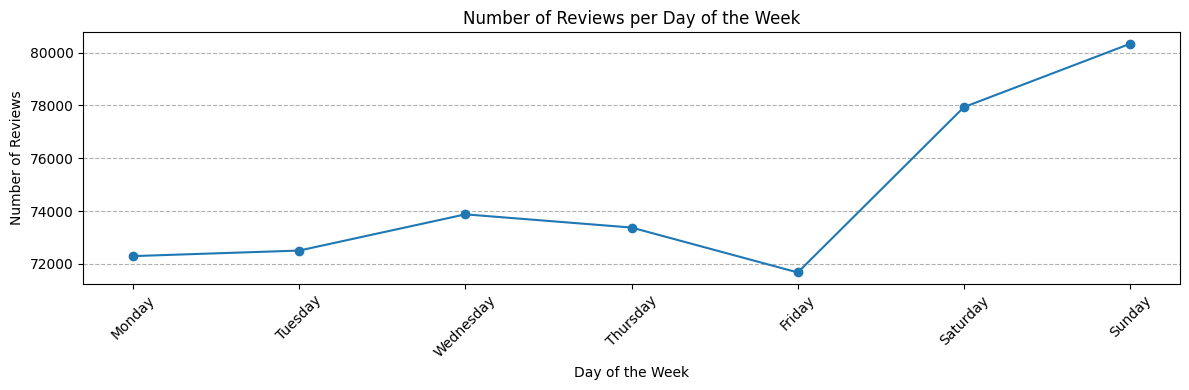


The workday with the most reviews is: Sunday


In [51]:
# 1.3.1 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).

# Convert 'newtime' to datetime objects
merged_df['newtime'] = pd.to_datetime(merged_df['newtime'])

# Extract the day of the week (0=Monday, 6=Sunday)
merged_df['day_of_week'] = merged_df['newtime'].dt.dayofweek

# Calculate the number of reviews per day of the week
reviews_per_day = merged_df['day_of_week'].value_counts().sort_index()

# Map day of week numbers to names
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
reviews_per_day.index = reviews_per_day.index.map(day_names)

# Plot the number of reviews per day of the week
plt.figure(figsize=(12,4))
reviews_per_day.plot(kind='line', marker='o')
plt.title('Number of Reviews per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Determine the workday with the most reviews
most_reviews_workday_index = reviews_per_day.idxmax()
print(f"\nThe workday with the most reviews is: {most_reviews_workday_index}")

In [61]:
# 1.3.2 Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you need to find out from 1.3.1), and find out which category those businesses are from?

# Filter the merged DataFrame for the workday with the most reviews (Sunday, which is day 6)
most_reviewed_day_df = merged_df[merged_df['day_of_week'] == 6]

# Group by business name and calculate the average rating for that day
avg_ratings_on_most_reviewed_day = most_reviewed_day_df.groupby('business_name')['rating'].mean().sort_values(ascending=False)

# Find the business names with the highest average rating on that day
# We can consider businesses with the maximum average rating on that specific day
max_avg_rating_value = avg_ratings_on_most_reviewed_day.max()
businesses_with_highest_avg_rating = avg_ratings_on_most_reviewed_day[avg_ratings_on_most_reviewed_day == max_avg_rating_value]

count = 0
print(f"\nBusinesses with the highest average rating ({max_avg_rating_value:.2f}) on {6}:")
for business_name in businesses_with_highest_avg_rating.index:
    # Find the category for each of these businesses from the original meta_business_df
    category = meta_business_df[meta_business_df['name'] == business_name]['category'].iloc[0]
    count = count + 1
    if count <= 15:
      print(f"{count}. Business Name: {business_name}\n\tCategory: {category}")

print("\nTotal number of businesses are :", count)


Businesses with the highest average rating (5.00) on 6:
1. Business Name: 13 Ravens Coffee & Books
	Category: ['Coffee shop', 'Book store', 'Cafe']
2. Business Name: 🚚Eagle Towing Anchorage Girdwood Eagle River Palmer Wasilla
	Category: ['Towing service', 'Transportation service']
3. Business Name: the Red Snapper Lounge
	Category: ['Bar', 'Liquor store', 'Lounge']
4. Business Name: bodyphlo
	Category: ["Women's clothing store", 'Clothing store', 'Dance store', 'Sportswear store', 'Swimwear store']
5. Business Name: 203 Kombucha
	Category: ['Tea house']
6. Business Name: Gardens at Bragaw
	Category: ['Garden']
7. Business Name: Gas & Diesel Doctor
	Category: ['Auto repair shop', 'Auto air conditioning service', 'Auto electrical service', 'Brake shop', 'Car repair and maintenance', 'Diesel engine repair service', 'Mechanic', 'Oil change service', 'Tire shop', 'Truck repair shop']
8. Business Name: Gastineau Channel
	Category: ['Channel']
9. Business Name: Gastineau Guiding Company
	Cat

1.3.3 Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

In [63]:
# 1. Analyze the distribution of reviews across different business categories (already done in previous cell but displaying again for context)
print("\nTop 10 Business Categories by Number of Reviews:")
display(reviews_per_category.head(10).to_frame(name='review_count'))


Top 10 Business Categories by Number of Reviews:


,review_count
category_list,
Restaurant,107511
Fast food restaurant,45337
American restaurant,42117
Tourist attraction,40428
Grocery store,35971
Breakfast restaurant,33621
Hamburger restaurant,32194
Coffee shop,29925
Takeout Restaurant,26210


In [64]:
# 2. Calculate the average rating for each business category (already done in previous cell but displaying again for context)
print("\nTop 10 Business Categories by Average Rating:")
display(avg_rating_per_category.head(10).to_frame(name='average_rating'))


Top 10 Business Categories by Average Rating:


,average_rating
category_list,
Debris removal service,5.0
Surf shop,5.0
Irrigation equipment supplier,5.0
Industrial equipment supplier,5.0
Dental implants provider,5.0
Water works equipment supplier,5.0
Oil field equipment supplier,5.0
Mining company,5.0
Medical spa,5.0


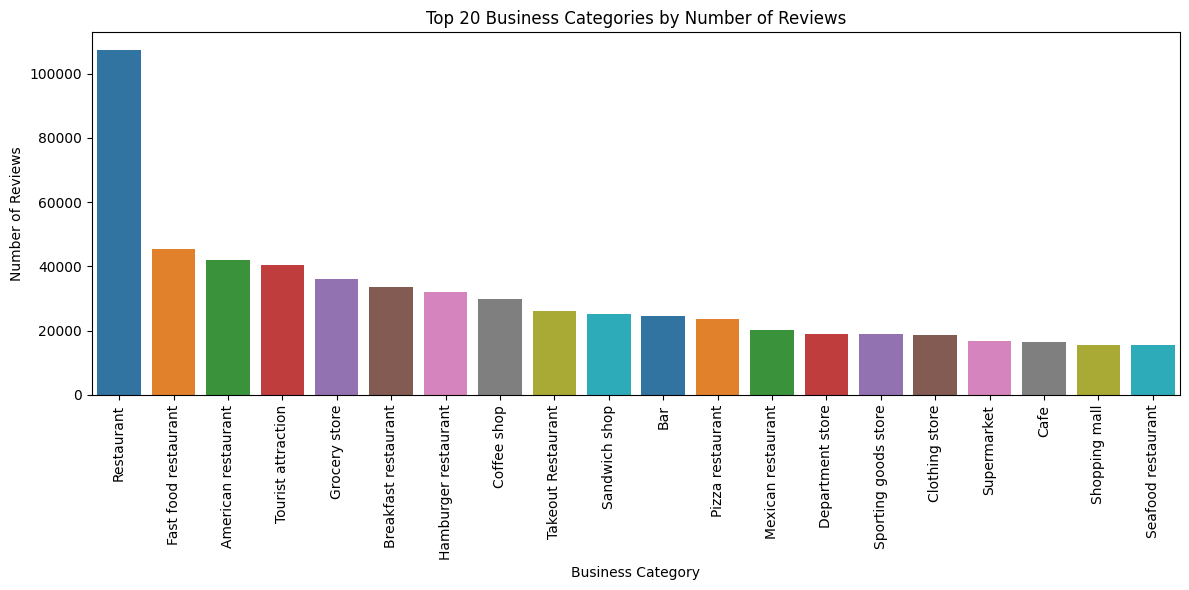

In [65]:
# Visualize the distribution of reviews across the top categories using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=reviews_per_category.head(20).index, y=reviews_per_category.head(20).values, palette='tab10', hue=reviews_per_category.head(20).index)
plt.title('Top 20 Business Categories by Number of Reviews')
plt.xlabel('Business Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

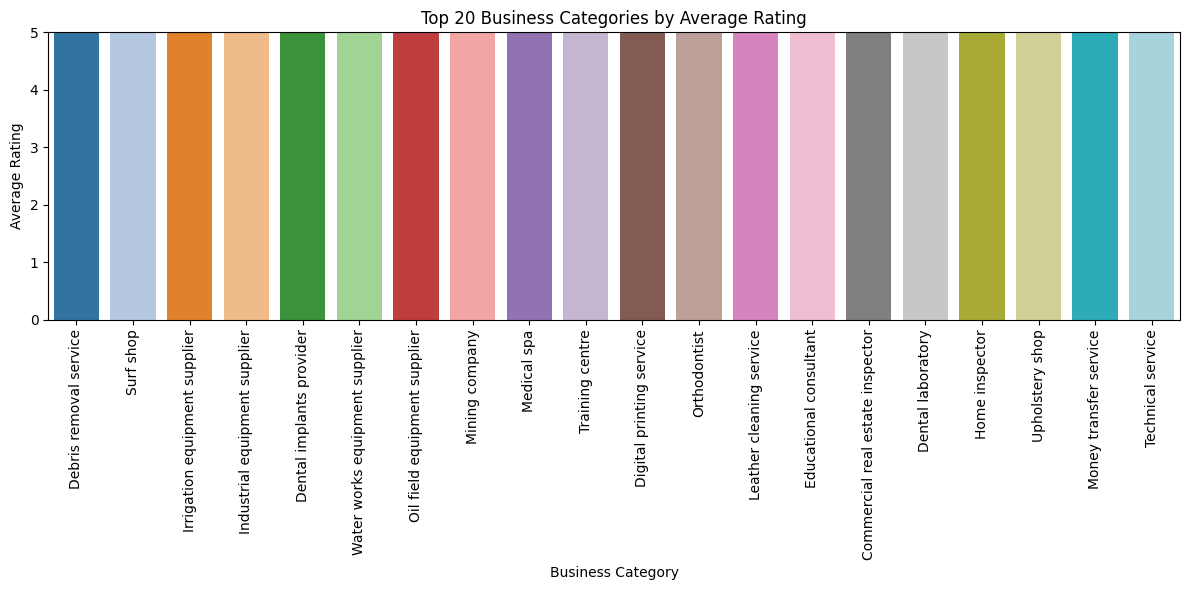

In [66]:
# Visualize the average ratings for the top categories using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_per_category.head(20).index, y=avg_rating_per_category.head(20).values, palette='tab20', hue=avg_rating_per_category.head(20).index)
plt.title('Top 20 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0, 5)
plt.show()

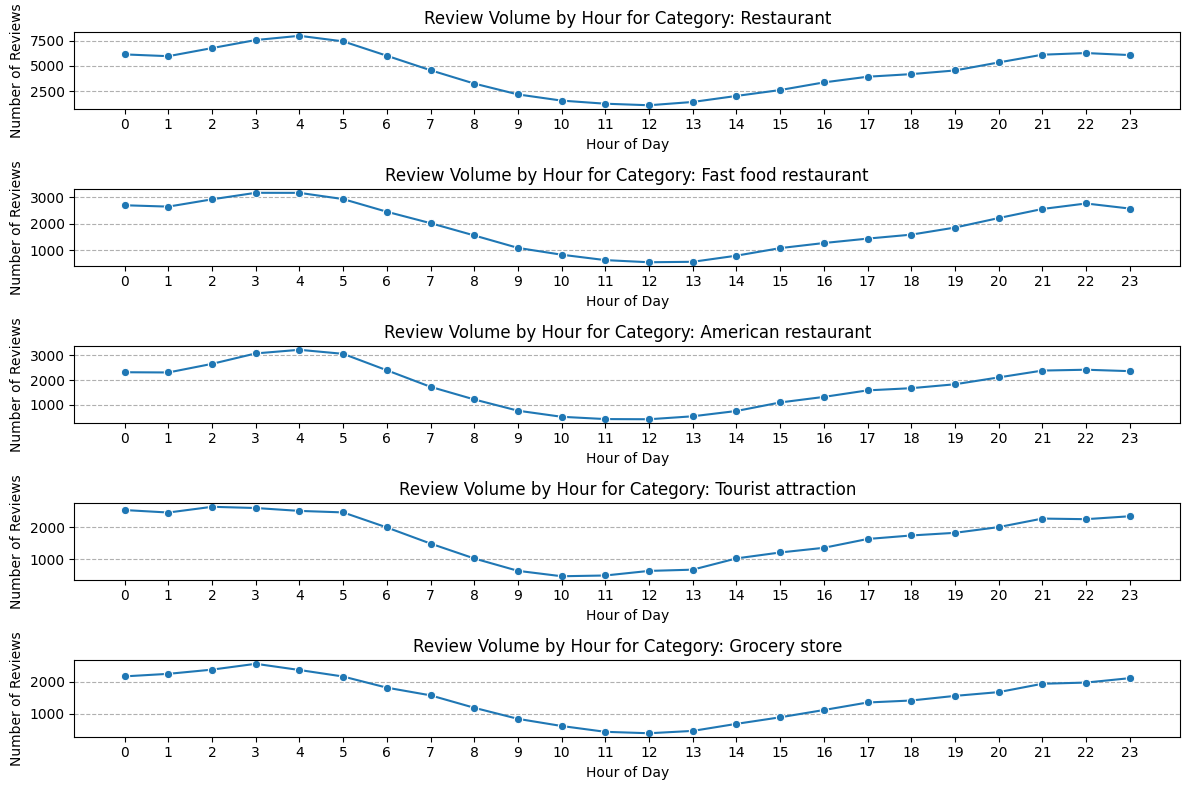

In [67]:
# Generate line plots showing the review volume by hour for the selected categories
plt.figure(figsize=(12, 8))
for i, category in enumerate(top_categories_for_peak_hours):
    plt.subplot(len(top_categories_for_peak_hours), 1, i + 1)
    category_df = categories_exploded_df[categories_exploded_df['category_list'] == category]
    reviews_by_hour = category_df['review_time'].value_counts().sort_index()
    sns.lineplot(x=reviews_by_hour.index, y=reviews_by_hour.values, marker='o')
    plt.title(f'Review Volume by Hour for Category: {category}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Reviews')
    plt.xticks(range(24))
    plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Sunday is the day of the week with the highest number of reviews.
*   Multiple businesses achieved a perfect average rating of 5.0 on Sunday across various categories, including coffee shops, towing services, bars, clothing stores, restaurants, and more.
*   The majority of reviews are concentrated in food service categories like 'Restaurant', 'Fast food restaurant', 'American restaurant', and 'Coffee shop', followed by retail and attraction categories.
*   Categories with the highest review volumes generally have high average ratings, typically between 4.0 and 4.5.
*   Peak review hours vary by category:
    *   Restaurants and fast food restaurants have peak activity in the evening hours.
    *   Tourist attractions show a broader distribution throughout the day with a potential late afternoon/evening peak.
    *   Grocery stores have a more even distribution with an increase in the afternoon and early evening.

### Insights or Next Steps

*   Businesses in high-volume categories like food service and retail should consider actively engaging with customers on Sundays to capitalize on peak review activity and encourage positive feedback.
*   Further analysis could explore the correlation between review volume and average rating within categories to understand if higher volume correlates with slightly lower (but still high) average ratings compared to niche categories.


## Q1.4

For the reviews on each of the submissions, work on all the review content and find out the top 30 most common words; Also generate separate word cloud visualizations for different years by grouping the reviews by review year and write down the insights in the markdown cell. Please also include your findings and visualizations in the report.

###Ans 1.4

##Q1.5
Let’s do some analysis on the business_name and the reviewers. Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level). Also, analyze the temporal patterns of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to conduct the analysis) and share your findings and insights in the markdown cell. Please also include your findings and insights (visualizations) in the report.

### Ans 1.5

##Q1.6
As the data scientist, you are required to build a recommendation for the business by using reviews, ratings, and its categories. In this task, you need to:

1.6.1 Write down your strategy of building the recommendation on business for customers in the markdown cell. You could create your own strategy or leverage the provided one here KNN on collaborative filtering. Please also include your strategy details in the report.

1.6.2 Could you please try to implement the strategy (code) you have written down for the recommendation system? Please give detailed explanation of your code and the logic in the comments and also interpret the recommendations with examples in the markdown cell. Please also include your implementation details and results in the report.

### Ans 1.6

##Q1.7

Continue work on the review data you have now, for each of the submissions of the review, you will need to explore the rating with other information:

1.7.1 Build visualization to explore the relationships of the rating and business categories. Please write down your insights in the markdown cell and also include your insights and visualizations in the report.

1.7.2 Let’s focus on the lower ratings now. Could you please find out the actual reviews on lower ratings and analyze on the reason? (You could use the common used words in lower rating reviews or design your own strategy with reasonable logic). Please also include your analysis details in the report.

###Ans 1.7

##Q1.8

Continue to work on the submission of the reviews, we would like to focus on the reviewer level with all the reviewed business history, but before we actually conduct the programming, we will need to finish few questions for exploration:

1.8.1 Check on the reviewer level reviewed business, sort the review of each business by the review time (newtime column) and then save the business name into the list variable user_business_list for each reviewer.

1.8.2 Check on the user_business_list, could you observe some repeated business names for the same user? If so, could you remove those duplicated business names under same user? Please print out the number of element in the user_business_list for each reviewer before removing the duplicated business name and after removing the duplicated business name.

1.8.3 Check on the user_business_list, could you find the user similarities according to their past reviewed business ? You are free to design your own strategy and give sufficient explanation in markdown cell and code implementation together. Please also include your strategy details and implementation in the report.

Hint: you might consider to use encoding for each of the business names and then calculate the difference of the users.

###Ans 1.8

# Part 2 - Submission Prediction

There are 3 questions in this part, totaling 40 marks. Each question is worth 10 marks. Additionally, the quality of your explanation in both the report and video will collectively be worth 10 marks.  
You are required to use Google Colab to finish all the coding in the code block cell, and provide sufficient coding comments, and also save the result of running as well.

##Q2.1

In this question, we will focus only on two information: total reviews per day with review time (newtime from the dataframe) to form the review volume time series. You are required to explore the review time series. There are some days not available in the review time series. Please add those days into the review time series with default number of review with the mean value of the number of review per day in the whole data (without any filtering on reviews). After that, decompose the submission review time series with addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the M05A material from lab session with default setting in seasonal_decompose function). Please also include your analysis details and implementation in the report.

###Ans 2.1

##Q2.2

We will try to use time series model ARIMA for forecasting the future. You need to find the best model with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices (you might need to split the time series to train and test with yourself with grid search according to the M05B material). Also, you are required to discuss with your group member on exploring the deep learning time series forecasting methods such as LSTM and RNN. Please write down your discussion around the necessary data wrangling and modeling steps (steps on how to achieve, not actual code). Also please give the reference of the deep learning time series forecasting models you are using. Please also include your discussion details and implementation in the report.

###Ans 2.2

##Q2.3

In this question, you are provided with the PDF file by Universities Australia via Indigenous Strategy annual report. You are required to critically analyze this report using your data science skills.

**Data Extraction** Carefully review the PDF and identify all relevant quantitative data, tables, and figures that can be extracted or digitized; Present any extracted data in a structured format (e.g., CSV, Excel table, or DataFrame);

**Data Analysis** Utilize your data analytics skills to discover common patterns or trends from the report; Where possible, compare trends over multiple years, between institutions, or across different Indigenous strategy metrics.

**Insights** Provide a clear and concise summary of the main patterns, trends, or correlations discovered from your analysis; Interpret what these findings reveal about the progress and challenges of Indigenous strategies in Australian universities.

You may use any data analytics tools or libraries you are comfortable with. All steps, from extraction to insights, should be clearly documented in your SIT742Task2Report.pdf, and source code should be in SIT742Task2Code.ipynb.

https://universitiesaustralia.edu.au/wp-content/uploads/2022/08/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf

###Ans 2.3

# Task
Analyze the review time and related gmap_id from the dataframe `df` and the data from "meta-business.csv". Join the two datasets on `gmap_id`. Determine which workday generates the most reviews and visualize the results. Identify the business names with the highest average ratings on that workday and their categories. Further explore the data on business names, categories, and peak hours using visualizations and tables, and summarize the findings in a markdown cell. Ensure all findings and visualizations are included in the report.

## Load meta-business data

### Subtask:
Load the meta-review-business.csv file into a pandas DataFrame.


**Reasoning**:
Load the meta-review-business.csv file into a pandas DataFrame and display the first 5 rows and its information.



**Reasoning**:
Join the two dataframes, `df` and `meta_business_df`, on the 'gmap_id' column to combine review information with business metadata.



**Reasoning**:
Convert the 'newtime' column to datetime objects and extract the day of the week to determine which workday has the most reviews.



**Reasoning**:
Identify the business names that have the highest averaged ratings on the workday with the most reviews (Sunday) and find out their categories.



**Reasoning**:
The previous code failed because the variable `most_reviewed_day_index` was not defined in that cell. I need to reuse the variable from the previous cell and then identify the business names that have the highest averaged ratings on the workday with the most reviews (Sunday) and find out their categories.



In [18]:
# Filter the merged DataFrame for the workday with the most reviews (Sunday, which is day 6)
most_reviewed_day_df = merged_df[merged_df['day_of_week'] == 6]

# Group by business name and calculate the average rating for that day
avg_ratings_on_most_reviewed_day = most_reviewed_day_df.groupby('business_name')['rating'].mean().sort_values(ascending=False)

# Find the business names with the highest average rating on that day
# We can consider businesses with the maximum average rating on that specific day
max_avg_rating_value = avg_ratings_on_most_reviewed_day.max()
businesses_with_highest_avg_rating = avg_ratings_on_most_reviewed_day[avg_ratings_on_most_reviewed_day == max_avg_rating_value]

# Determine the workday with the most reviews again to use in the print statement
most_reviewed_day_index = reviews_per_day.idxmax()

print(f"\nBusinesses with the highest average rating ({max_avg_rating_value:.2f}) on {most_reviewed_day_index}:")
for business_name in businesses_with_highest_avg_rating.index:
    # Find the category for each of these businesses from the original meta_business_df
    category = meta_business_df[meta_business_df['name'] == business_name]['category'].iloc[0]
    print(f"- Business Name: {business_name}, Category: {category}")


Businesses with the highest average rating (5.00) on Sunday:
- Business Name: 13 Ravens Coffee & Books, Category: ['Coffee shop', 'Book store', 'Cafe']
- Business Name: 🚚Eagle Towing Anchorage Girdwood Eagle River Palmer Wasilla, Category: ['Towing service', 'Transportation service']
- Business Name: the Red Snapper Lounge, Category: ['Bar', 'Liquor store', 'Lounge']
- Business Name: bodyphlo, Category: ["Women's clothing store", 'Clothing store', 'Dance store', 'Sportswear store', 'Swimwear store']
- Business Name: 203 Kombucha, Category: ['Tea house']
- Business Name: Gardens at Bragaw, Category: ['Garden']
- Business Name: Gas & Diesel Doctor, Category: ['Auto repair shop', 'Auto air conditioning service', 'Auto electrical service', 'Brake shop', 'Car repair and maintenance', 'Diesel engine repair service', 'Mechanic', 'Oil change service', 'Tire shop', 'Truck repair shop']
- Business Name: Gastineau Channel, Category: ['Channel']
- Business Name: Gastineau Guiding Company, Categor

**Reasoning**:
Explore the data on business name, categories, and peak hours for insights using visualizations and tables. Specifically, analyze the distribution of reviews across different business categories, the average rating per category, and potentially the peak review hours for the most reviewed categories.




Top 20 Business Categories by Number of Reviews:


,review_count
category_list,
Restaurant,107511
Fast food restaurant,45337
American restaurant,42117
Tourist attraction,40428
Grocery store,35971
Breakfast restaurant,33621
Hamburger restaurant,32194
Coffee shop,29925
Takeout Restaurant,26210


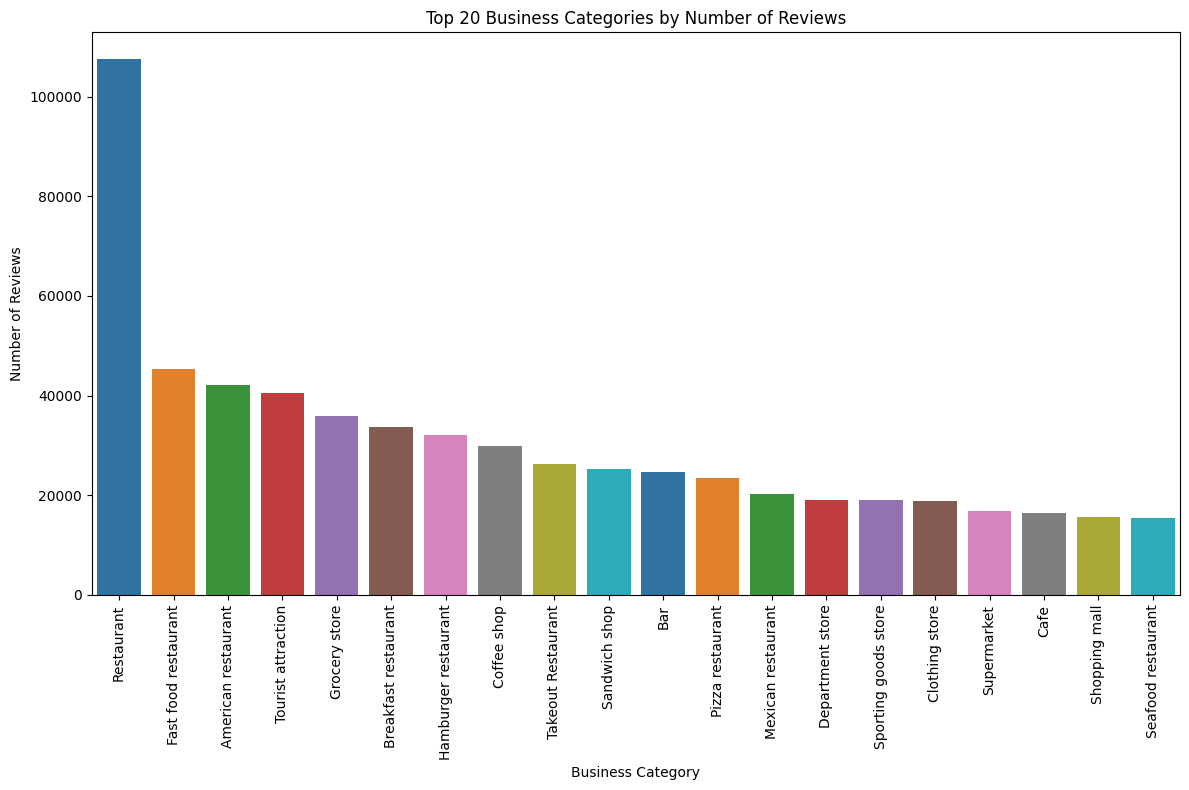


Top 20 Business Categories by Average Rating:


,average_rating
category_list,
Debris removal service,5.0
Surf shop,5.0
Irrigation equipment supplier,5.0
Industrial equipment supplier,5.0
Dental implants provider,5.0
Water works equipment supplier,5.0
Oil field equipment supplier,5.0
Mining company,5.0
Medical spa,5.0


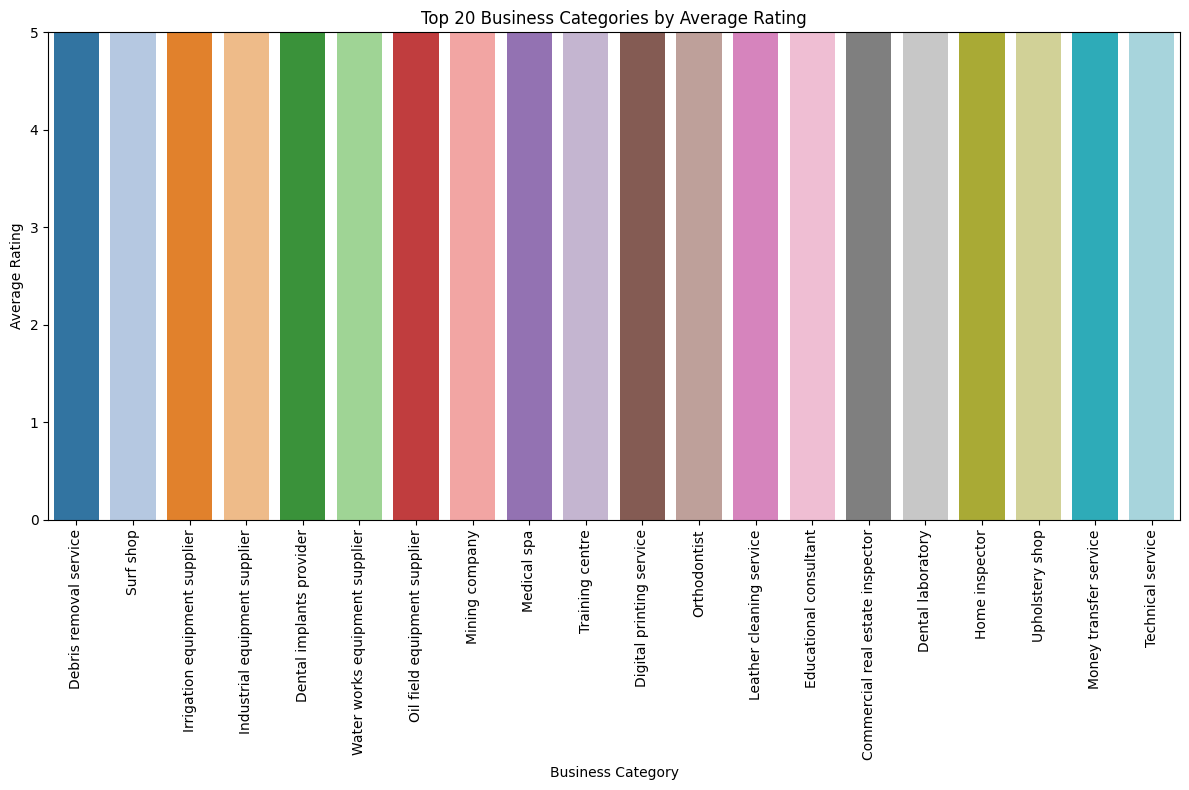


Peak Review Hours for Top Categories: ['Restaurant', 'Fast food restaurant', 'American restaurant', 'Tourist attraction', 'Grocery store']


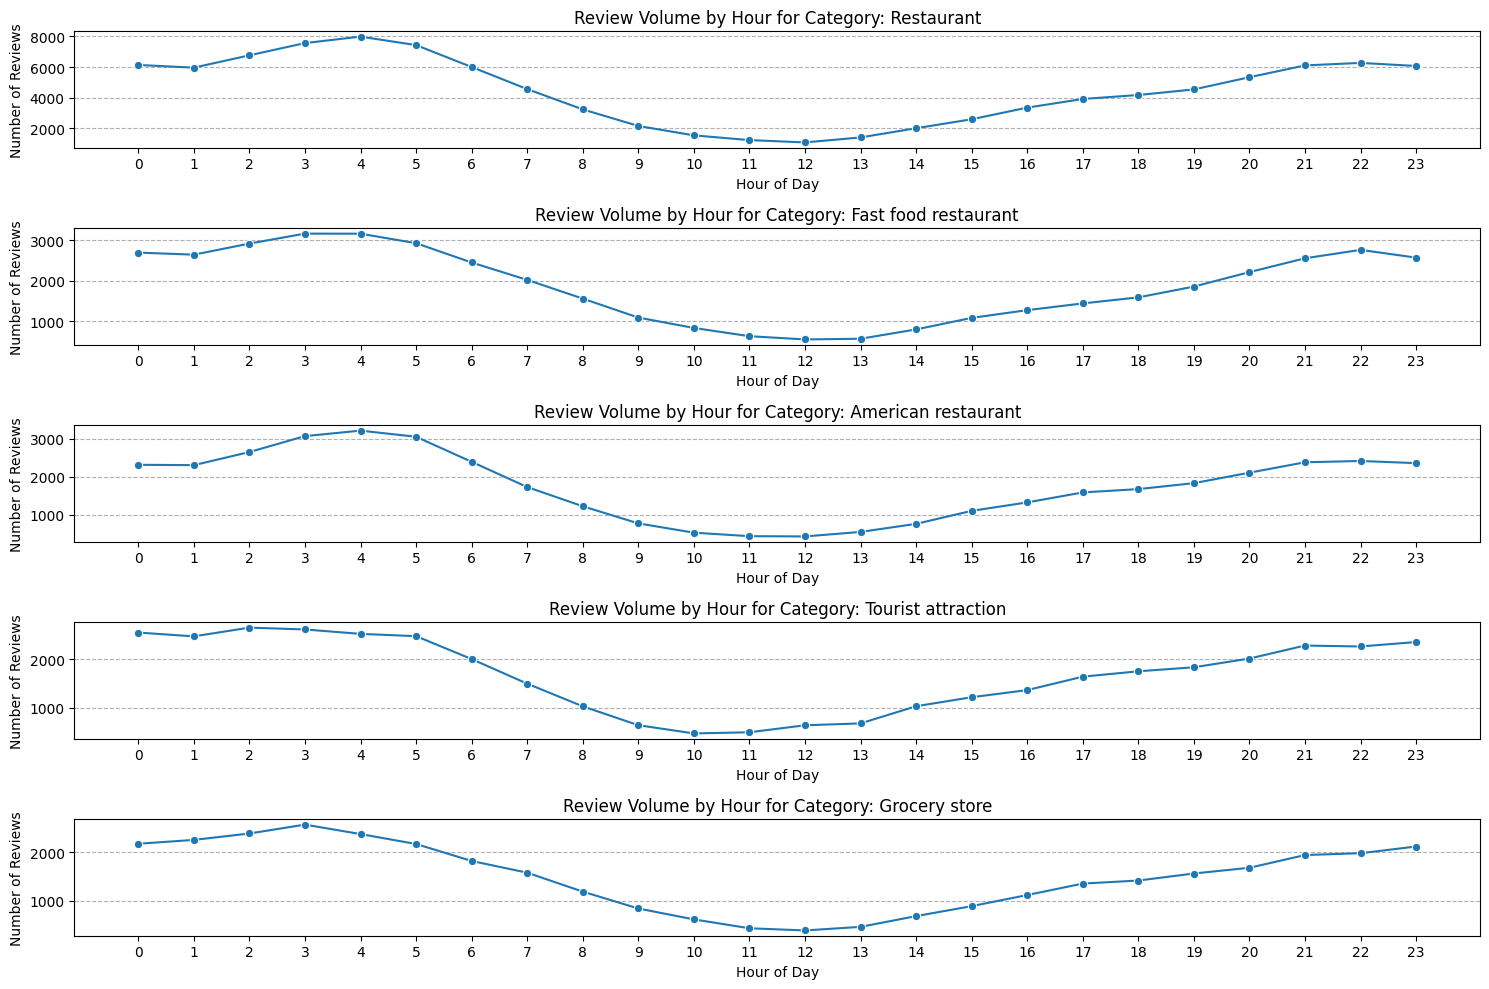

In [19]:
# Explore the distribution of reviews across different business categories
# Need to handle the string representation of lists in the 'category' column first
# Safely evaluate the string representation of lists
merged_df['category_list'] = merged_df['category'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# Explode the list of categories to have one category per row
categories_exploded_df = merged_df.explode('category_list')

# Count the number of reviews per category
reviews_per_category = categories_exploded_df['category_list'].value_counts()

# Display the top 20 categories by number of reviews
print("\nTop 20 Business Categories by Number of Reviews:")
display(reviews_per_category.head(20).to_frame(name='review_count'))

# Plot the top 20 categories by number of reviews
plt.figure(figsize=(12, 8))
sns.barplot(x=reviews_per_category.head(20).index, y=reviews_per_category.head(20).values, palette='tab10', hue=reviews_per_category.head(20).index)
plt.title('Top 20 Business Categories by Number of Reviews')
plt.xlabel('Business Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate the average rating per category
avg_rating_per_category = categories_exploded_df.groupby('category_list')['rating'].mean().sort_values(ascending=False)

# Display the top 20 categories by average rating
print("\nTop 20 Business Categories by Average Rating:")
display(avg_rating_per_category.head(20).to_frame(name='average_rating'))

# Plot the top 20 categories by average rating
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_rating_per_category.head(20).index, y=avg_rating_per_category.head(20).values, palette='tab20', hue=avg_rating_per_category.head(20).index)
plt.title('Top 20 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim(0, 5) # Ratings are between 0 and 5
plt.show()

# Explore peak review hours for some of the most reviewed categories
# Select a few top categories for this analysis
top_categories_for_peak_hours = reviews_per_category.head(5).index.tolist()

print(f"\nPeak Review Hours for Top Categories: {top_categories_for_peak_hours}")

plt.figure(figsize=(15, 10))
for i, category in enumerate(top_categories_for_peak_hours):
    plt.subplot(len(top_categories_for_peak_hours), 1, i + 1)
    category_df = categories_exploded_df[categories_exploded_df['category_list'] == category]
    reviews_by_hour = category_df['review_time'].value_counts().sort_index()
    sns.lineplot(x=reviews_by_hour.index, y=reviews_by_hour.values, marker='o')
    plt.title(f'Review Volume by Hour for Category: {category}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Reviews')
    plt.xticks(range(24))
    plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

## Further exploration

### Subtask:
Explore the relationship between business names, categories, and review hours. Use visualizations (e.g., bar plots, box plots) and/or tables to present findings. Summarize the insights in a markdown cell.


**Reasoning**:
Explore the relationship between business names, categories, and review hours by analyzing the distribution of reviews across categories, calculating average ratings per category, identifying top categories, visualizing these distributions and ratings, and exploring peak review hours for top categories.



**Reasoning**:
Summarize the findings from the visualizations and tables, highlighting patterns related to categories, ratings, and peak hours as requested by the subtask.

